In [1]:
# This is an implementation for the GoogLeNet v1 based on
# https://github.com/tflearn/tflearn/blob/master/examples/images/googlenet.py
# for the plantvillage input-space

In [1]:
from __future__ import division, absolute_import

import tensorflow as tf
import tflearn

from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression

from google.protobuf import text_format
import h5py

import numpy as np

import os
from datetime import datetime

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
def inception_unit_v1(layer_in, unit):
    nb_filters = { '3a' : [64,  96,  128, 16, 32, 32], \
                   '3b' : [128, 128, 192, 32, 96, 64], \
                   '4a' : [192, 96,  208, 16, 48, 64], \
                   '4b' : [160, 112, 224, 24, 64, 64], \
                   '4c' : [128, 128, 256, 24, 64, 64], \
                   '4d' : [112, 144, 288, 32, 64, 64], \
                   '4e' : [256, 160, 320, 32, 128, 128], \
                   '5a' : [256, 160, 320, 32, 128, 128], \
                   '5b' : [384, 192, 384, 48, 128, 128] }
    
    layer_1_1 = conv_2d(layer_in, nb_filters[unit][0], filter_size = 1, activation = 'relu', \
                            name = 'inception_{0}_1x1'.format(unit) )

    layer_3_3_red = conv_2d(layer_in, nb_filters[unit][1], filter_size = 1, activation = 'relu', \
                            name = 'inception_{0}_3x3_reduce'.format(unit))
    layer_3_3 = conv_2d(layer_3_3_red, nb_filters[unit][2], filter_size = 3,  activation = 'relu', \
                            name = 'inception_{0}_3x3'.format(unit))

    layer_5_5_red = conv_2d(layer_in, nb_filters[unit][3], filter_size = 1, activation = 'relu', \
                            name = 'inception_{0}_5x5_reduce'.format(unit))
    layer_5_5 = conv_2d(layer_5_5_red, nb_filters[unit][4], filter_size = 5, strides = 1, \
                            padding = 'same', activation = 'relu', \
                            name = 'inception_{0}_5x5'.format(unit))

    layer_pool = max_pool_2d(layer_in, kernel_size = 3, strides = 1, \
                            name = 'inception_{0}_pool'.format(unit))
    layer_pool_p = conv_2d(layer_pool, nb_filters[unit][5], filter_size = 1, activation = 'relu', \
                            name = 'inception_{0}_pool_proj'.format(unit))

    layer_out = merge([ layer_1_1, \
                        layer_3_3, \
                        layer_5_5, \
                        layer_pool_p ], \
                       mode = 'concat', axis = 3, \
                       name = 'inception_{0}_output'.format(unit))
    return layer_out

In [3]:
inception_unit = inception_unit_v1

In [4]:
#reset graph

tf.reset_default_graph()
Graph = tf.get_default_graph()
with tf.Session(graph=tf.Graph()) as sess:
    tflearn.config.init_graph(log_device = True, gpu_memory_fraction = 0.7)
    tflearn.config.is_training (True)

In [5]:
SIZE_WH = 256 ##(original input was 224x224x3)
N_CLASSES = 38 #N_CLASSES = 38, 29, 13
activation_fn = 'softmax'
optimizer_algo = 'momentum'
loss_objective = 'categorical_crossentropy'
#metric = tflearn.metrics.Top_k(k=5)
metric = recall()
#tf.train.AdamOptimizer
ln_rate = 0.001

model_name_short = 'model_googlenet_v1_plantvillage_{0}'.format(metric.name)
model_name = '{0}_{1}_{2}_{3}'.format(model_name_short, activation_fn, optimizer_algo, loss_objective)
model_directory = '{0}/{1}'.format(os.getcwd(), model_name)
model_pb = '{0}/{1}/{1}.pbtxt'.format(os.getcwd(), model_name)
model_path = '{0}/{1}/{1}.tflearn'.format(os.getcwd(), model_name)
checkpoint_path = '{0}/{1}/{1}'.format(os.getcwd(),model_name)
log_dir = '{0}/tflearn_logs/'.format(os.getcwd())

if not os.path.isdir(model_directory):
    os.mkdir(model_directory)
print(model_name)

model_googlenet_v1_plantvillage_top5_softmax_momentum_categorical_crossentropy


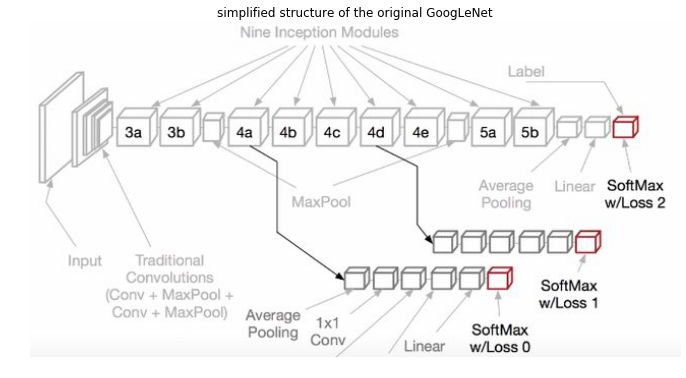

In [7]:
url = 'https://i.stack.imgur.com/U6O7Wl.png'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.figure(figsize=(14, 6))
plt.imshow(img)
plt.axis('off')
plt.title('simplified structure of the original GoogLeNet')
plt.show()

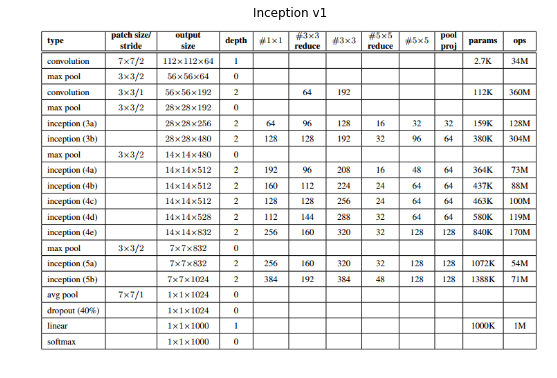

In [8]:
path = './GoogLeNet-TF-Implementations/Inception_GoogLeNet_V1.PNG'
img = Image.open(path)

plt.figure(figsize=(14, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Inception v1')
plt.show()

In [9]:
#MetaGraph  definition starts here
#The load operation requires the following information:

#The session in which to restore the graph definition and variables.
#The tags used to identify the MetaGraphDef to load.
#The location (directory) of the SavedModel.

In [10]:
#(0)
#input layer (note: normalized at runtime for float. input is untouched uint8 additive rgb intensity)
#tf.placeholder = 
net_input = input_data(shape = [None, SIZE_WH, SIZE_WH, 3], dtype = tf.float32, \
                           name = 'InputData')
#256x256x3
#[<tf.Tensor 'data/X:0' shape=(?, 256, 256, 3) dtype=float32>]

In [12]:
#(1)
#1st convolution layer (output is halved due to strides)
conv1_7_7 = conv_2d(net_input, nb_filter = 64, filter_size = 7, padding = 'same', \
                    strides = 2, activation = 'relu', name = 'conv1_7x7_s2')
#128x128x64

In [13]:
#(2)
#max pool layer
pool1_3_3 = max_pool_2d(conv1_7_7, kernel_size = 3, strides = 2, \
                           name = 'pool1_3x3_s2')
#(output is 64x64x64)

In [14]:
#local response normalization layer
pool1_3_3 = local_response_normalization(pool1_3_3, alpha = 0.00002, beta = 0.75, \
                           name = 'pool1_norm1')

In [15]:
#(3)
#pseudo-inception layer (non-productive reduction layer)
conv2_3_3_red = conv_2d(pool1_3_3, nb_filter = 64, filter_size = 1, activation=  'relu', \
                           name = 'conv2_3x3_reduce')
conv2_3_3 = conv_2d(conv2_3_3_red, nb_filter = 192, filter_size = 3, activation = 'relu', \
                           name = 'conv2_3x3')
conv2_3_3 = local_response_normalization(conv2_3_3, name = 'conv2_norm2' )
#outputs 192 features
#64x64x192

In [16]:
#(4)
#max pool layer (shrink receptive field with growing # of feature)
pool2_3_3 = max_pool_2d(conv2_3_3, kernel_size = 3, strides = 2, \
                          name = 'pool2_3x3_s2')
#32x32x192

In [17]:
#(5)
#1st inception unit (3rd convolutional layer)
inception_3a = inception_unit(pool2_3_3, '3a')

#32x32x32

#64+128+32+32=32*2+32*2+32*4=32*8=256
#32x32x256

In [18]:
#(6)
#2nd inception unit
inception_3b = inception_unit(inception_3a, '3b')

In [19]:
#(7)
#max pool layer
pool3_3_3 = max_pool_2d(inception_3b, kernel_size = 3, strides = 2, \
                            name = 'pool3_3x3_s2')
#16x16x480

In [20]:
#(8)
#3rd inception unit
inception_4a = inception_unit(pool3_3_3, '4a')

#16x16x512

In [21]:
#first softmax (training only)
loss_1_pool = avg_pool_2d(inception_4a, kernel_size = 5, strides = 3, \
                            name = 'loss1_ave_pool')
loss_1_conv = conv_2d(loss_1_pool, nb_filter = 128, filter_size = 1, activation = 'relu', \
                            name= 'loss1_conv')

#Fully connected layer; SoftMax activation #1
loss_1_fc = fully_connected(loss_1_conv, n_units = 1024, activation = 'relu', \
                            name = 'loss1_fc')
#drouput?

In [22]:
#(9)
#4th inception unit
inception_4b = inception_unit(inception_4a, '4b')

#16x16x512

In [23]:
#(10)
#5th inception unit
inception_4c = inception_unit(inception_4b, '4c')

#16x16x512

In [24]:
#(11)
#6th inception unit
inception_4d = inception_unit(inception_4c, '4d')

#16x16x528

In [25]:
#second softmax (training only)
loss_2_pool = avg_pool_2d(inception_4d, 5, strides = 3, \
                            name = 'loss2_ave_pool')
loss_2_conv = conv_2d(loss_2_pool, 128, filter_size = 1, activation = 'relu', \
                            name = 'loss2_conv')
loss_2_fc = fully_connected(loss_2_conv, 1024, activation = 'linear', \
                            name = 'loss2_fc')

In [26]:
#(12)
#7th inception unit
inception_4e = inception_unit(inception_4d, '4e')

#16x16x832

In [27]:
#(13)
#maxpool layer
pool4_3_3 = max_pool_2d(inception_4e, kernel_size = 3, strides = 2, \
                            name = 'pool4_3x3_s2')
#8x8x832

In [28]:
#(14)
#8th inception unit
inception_5a = inception_unit(pool4_3_3, '5a')

#8x8x832

In [29]:
#(15)
#9th and final inception unit
inception_5b = inception_unit(inception_5a, '5b')

#8x8x1024 (768+256=1024)

In [30]:
#(16)
#average pool layer
pool5_7_7 = avg_pool_2d(inception_5b, kernel_size = 7, strides = 1, padding = 'VALID', \
                            name = 'pool5_7x7_s1')
#2x2x1024

In [31]:
#(17)
pool5_7_7_drop = dropout(pool5_7_7, keep_prob = 0.4, name = 'pool5_drop_7x7')
#2x2x1024
#1x1x1024

In [33]:
#(18) only "pure" fully connected layer
loss_3_fc = fully_connected(pool5_7_7_drop, n_units = 1000, activation = 'linear', \
                            name = 'loss3_classifier')
#1x1x1000

In [34]:
#MetaGraph definition ends here (minus the optimization its corresponding loss layer)

#start of googlenet computational model

In [35]:
#metric = tflearn.metrics.Top_k(k=1)

In [36]:
#optimizer
#loss: A Tensor containing the value to minimize.
#var_list: Optional list or tuple of tf.Variable to update to minimize loss. Defaults to the list of variables collected in the graph under the key GraphKey.TRAINABLE_VARIABLES.

In [37]:
#Fully connected layer; SoftMax activation #1 #Fully connected layer; SoftMax activation #2 
#classifier1 = fully_connected(loss1_fc, N_CLASSES, activation = 'softmax')
classifier1 = fully_connected(loss_1_fc, N_CLASSES, activation = activation_fn, \
                            name = 'loss1_classifier')
#transform_dropout: float: Keep probability on the highway transform gate.
#metrics (top-1, top-5)

In [38]:
#Fully connected layer; SoftMax activation #2 (should not be implemented)
#classifier2 = fully_connected(loss2_fc, N_CLASSES, activation = 'softmax')
classifier2 = fully_connected(loss_2_fc, N_CLASSES, activation = activation_fn, \
                            name = 'loss2_classifier')
#metrics (top-1, top-5)

In [39]:
#Fully connected layer; SoftMax activation #3
#classifier3 = fully_connected(loss3_fc, N_CLASSES, activation = activation_fn, \
#                           name = 'prob')
classifier3 = fully_connected(loss_3_fc, N_CLASSES, activation = activation_fn, \
                           name = 'loss3_classifier')
#tf.confusion_matrix(tf.argmax(y, 1), tf.argmax(y_, 1))

In [40]:
#if tflearn.is_training(True):
classifiers = tf.stack([ classifier1, classifier2, classifier3 ], axis = 2, \
                           name = 'training_classifiers')
classifiers_mean = tf.reduce_mean(classifiers, axis = 2, \
                           name = 'classifier_mean')
# "classifiers_mean/Softmax:0"

In [42]:
# The optimizer layer loss function and optimizater)
network = regression(classifiers_mean, optimizer = optimizer_algo, \
                     loss = loss_objective, \
                     learning_rate =  ln_rate, \
                     metric = metric, \
                     n_classes = N_CLASSES)
#256x256x38
#<tf.Operation 'TargetsData/Y' type=Placeholder>

In [41]:
# model trainer setup
model = tflearn.DNN(network, checkpoint_path = checkpoint_path, \
                    max_checkpoints = 5, \
                    tensorboard_verbose = 3, \
                    tensorboard_dir = log_dir)
print(model_name)

model_googlenet_v1_plantvillage_top5_softmax_momentum_categorical_crossentropy


In [42]:
file_h5f = '/home/martin/Pictures/h5s_plantvillage/plantvillage_svm.h5'

# read plantvillage image dataset
h5f = h5py.File(file_h5f, 'r')
#images
X = h5f['X']
#labels
Y = h5f['Y']

#train model
model.fit(X, Y, n_epoch = 50, validation_set = 0.2, shuffle = True, \
                show_metric = True, batch_size = 64, snapshot_step = 50, \
                snapshot_epoch = False, run_id = model_name)
h5f.close()

#Training Step: 5500  | total loss: 1.40105 | time: 404.529s
#| Momentum | epoch: 050 | loss: 1.40105 - top5: 0.9186 
#| val_loss: 1.53021 - val_acc: 0.8824 -- iter: 7000/7000

Training Step: 5499  | total loss: 1.12685 | time: 335.914s
| Momentum | epoch: 050 | loss: 1.12685 - top5: 0.9459 -- iter: 6976/7000
Training Step: 5500  | total loss: 1.10870 | time: 353.503s
| Momentum | epoch: 050 | loss: 1.10870 - top5: 0.9466 | val_loss: 1.38959 - val_acc: 0.9160 -- iter: 7000/7000
--


In [43]:
#end of training stage

In [44]:
#save weight to file (protobuf)
model.save(model_path)

In [45]:
#save (a textual model of) graph to file
sess = tf.Session()

model_pb = '{0}/{1}/{1}.pbtxt'.format(os.getcwd(), model_name)
with sess.as_default():
  assert tf.get_default_session() is sess
tf.train.write_graph(sess.graph_def, log_dir, model_pb)

'/home/martin/Python/model_googlenet_v1_plantvillage_top5_softmax_momentum_categorical_crossentropy/model_googlenet_v1_plantvillage_top5_softmax_momentum_categorical_crossentropy.pbtxt'

In [ ]:
#below is playtesting of results

In [ ]:
'''#reload saved model weights (requires prebuilt graph)
tf.initialize_all_variables()
# model trainer setup
model = tflearn.DNN(network, checkpoint_path = checkpoint_path, \
                    max_checkpoints = 5, \
                    tensorboard_verbose = 3, \
                    tensorboard_dir = log_dir)
print(model_name)
model.load(model_path)
tflearn.config.is_training(False)'''

In [ ]:
model.load(model_path)

In [ ]:
# naive model evaluation
h5f = h5py.File(file_h5f, 'r')
X = h5f['X']
Y = h5f['Y']

(count_t, count_f) = (0, 0)
for i in range(10000):
    pred = model.predict(X[i:i+1,:,:,:]).argmax()
    true = Y[i:i+1].argmax()
    if (pred == true):
        count_t +=1
    else:
        count_f +=1
print('good: {0}'.format(count_t))
print('bad: {0}'.format(count_f))
h5f.close()

In [ ]:
LIMIT = 1000 #save time by evaulating only a part

h5f = h5py.File(file_h5f, 'r')
X = h5f['X']
Y = h5f['Y']
k = 35

top_op = tflearn.metrics.top_k_op(model.predict(X[0:LIMIT,:,:,:]), Y[0:LIMIT,:], k)
# Calculate Top-K accuracy 
top_accuracy = sess.run(top_op)
print('top-{0} accuracy is {1}%'.format(k, top_accuracy*100))

h5f.close()

In [43]:
inputs = tf.get_collection(tf.GraphKeys.INPUTS)
targets = tf.get_collection(tf.GraphKeys.TARGETS)
print inputs
print targets

[<tf.Tensor 'InputData/X:0' shape=(?, 256, 256, 3) dtype=float32>]
[<tf.Tensor 'TargetsData/Y:0' shape=(?, 38) dtype=float32>]
